In [205]:
import sys
import os
import re
import pandas as p
from pydub import AudioSegment
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
import csv_combo
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier


In [148]:
def find_file(filenames, begin, end):
    """
    filenames: list of filenames
    begin: first number to look for in filename
    end: second number to look for in filename
    return: the first filename that contains both begin and end, or None if it doesn't exist
    """
    filenames = sorted(filenames)
    pattern = re.compile(r'.(\d+)-.(\d+)') # TODO only works with current filename formatting
    b_str = str(begin)
    e_str = str(end)
    for name in filenames:
        m = pattern.match(name)
        if m is None:
            continue
        if b_str == m.group(1) and e_str == m.group(2):
            return name
    return None

In [149]:
def get_begin_end(timepoint):
    """
    timepoint: string from timepoint column
    return: pair of ints (first timepoint in seconds, second timepoint in seconds)
    """
    print(timepoint)
    times = timepoint.split('-')
    assert len(times) == 2
    begintime = times[0]
    endtime = times[1]
    begintime_split = begintime.split(':')
    assert len(begintime_split) == 2
    if begintime_split[0] == "":
        begin = int(begintime_split[1])
    else:
        begin = 60 * int(begintime_split[0]) + int(begintime_split[1])
    endtime_split = endtime.split(':')
    assert len(endtime_split) == 2
    if endtime_split[0] == "":
        end = int(endtime_split[1])
    else:
        end = 60 * int(endtime_split[0]) + int(endtime_split[1])
    return begin, end

In [150]:
def augment_dataframes(spreadsheet_dict, datadir, filter=True):
    """
    spreadsheet_dict: dictionary loaded by get_all_spreadsheets
    datadir: directory containing subdirectories 'Codes' and 'Videos'
    filter: boolean. If True, only include rows with Mode 3, 15, or 18.

    return: nothing. This function mutates spreadsheet_dict by
    augmenting each dataframe to add the 'Audio Clip' column containing
    20-second audio snippets.
    """
    keys = list(spreadsheet_dict.keys())
    i = 0
    for excel_filename in keys:
        df = spreadsheet_dict[excel_filename]
        print('Now augmenting dataframe for', excel_filename)
        assert len(excel_filename) >= 8
        filename_prefix = excel_filename[:8]
        audios_dir = os.path.join(datadir, 'SplitVideos', filename_prefix)
        print('audios_dir:', audios_dir)
        audio_files = os.listdir(audios_dir)
        # Load file for each row, create new column, add that column
        audios = []
        energies = []
        mfccs = []
        debug = True
        j = 0
        for tp in df['Timepoint']:
            b, e = get_begin_end(tp)
            fname = find_file(audio_files, b, e)
            if debug:
                print('tp:', tp, '\tfname:', fname, '\tb:', b, '\te:', e)
            if fname is None:
                print('WARNING: file for "{}" is missing'.format(tp))
                audio = None
            else:
                audio,sample_rate = librosa.load(os.path.join(audios_dir,fname),res_type="kaiser_fast")
                
                energy = librosa.feature.rms(y=audio)
                energy = energy[0]
                avg_energy = sum(energy)/len(energy)
                
                
                #plt.figure(figsize=(12,4))
                #plt.plot(audio)
                #plt.show()
                #print(df['Mode'][j])
                
                mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
                mfccs_processed = np.mean(mfcc.T,axis=0)
                avg_mfcc = sum(mfccs_processed)/(len(mfccs_processed))

                audio = np.stack(audio)
                energy = np.stack(energy)
                mfccs_processed = np.stack(mfccs_processed)
                #audio = AudioSegment.from_wav(os.path.join(audios_dir, fname))
                # NOTE: if file fails to load, pydub handles it by truncating audio data
                #if debug:
                    #print('Length of raw bytes loaded:', len(audio.raw_data))
                j += 1
            audios.append(audio)
            energies.append(energy)
            mfccs.append(mfccs_processed)

            
        df['Audio Clip'] = audios
        df['Energy'] = energies
        df['Avg MFCC'] = mfccs
        print('Number of rows:', df.shape[0])
        if filter:
            print('Filtering by mode: 3, 15, or 18')
            df_filtered = df[df['Mode'].isin([3, 15, 18])]
            print('Number of rows:', df_filtered.shape[0])
        else:
            df_filtered = df
        
        spreadsheet_dict[excel_filename] = df_filtered
        i += 1

        """#print('Starting logistic regression for', excelfile)
        df_nonnull = df_filtered[~df_filtered['Audio Clip'].isnull()]
        labels = df_nonnull['Mode'].tolist()
        labels_binary = [(1 if label == 3 else 0) for label in labels]
        print('Binary labels (1 means mode 3, 0 means mode 15/18):', labels_binary)
        audios_list = [np.array(a.get_array_of_samples()) for a in df_nonnull['Audio Clip']]
        audios_array = np.stack(audios_list)
        print('audios_array.shape:', audios_array.shape)
        lrmodel = LR()
        lrmodel.fit(audios_array, labels_binary)
        print('Logistic regression score:')
        s = lrmodel.score(audios_array, labels_binary)
        print(s)
        break"""

In [151]:
def load_and_augment_data(datadir):
    """
    This is the primary function to perform data loading and cleaning.

    datadir: dir containing subdirectories 'Videos' and 'Codes', as well as 'SplitVideos'
    return: a spreadsheet_dict object augmented by augment_dataframes
    """
    
    spreadsheet_dict = csv_combo.get_all_spreadsheets(datadir)
    print(len(spreadsheet_dict))
    augment_dataframes(spreadsheet_dict, datadir)
    return spreadsheet_dict

In [152]:
# Feedforward Nueral Network Model
def build_model_graph(input_shape=(20,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('softmax'))
        # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
    return model

In [79]:
df = load_and_augment_data("TBOP coding samples")


21
Now augmenting dataframe for 10112_R2_With time.xlsx
audios_dir: TBOP coding samples\SplitVideos\10112_R2
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :40-1:00 	fname: _40-_60.wav 	b: 40 	e: 60
1:00 - 1:20
tp: 1:00 - 1:20 	fname: _60-_80.wav 	b: 60 	e: 80
1:20-1:40
tp: 1:20-1:40 	fname: _80-_100.wav 	b: 80 	e: 100
1:40-2:00
tp: 1:40-2:00 	fname: _100-_120.wav 	b: 100 	e: 120
2:00 - 2:20
tp: 2:00 - 2:20 	fname: _120-_140.wav 	b: 120 	e: 140
2:20-2:40
tp: 2:20-2:40 	fname: _140-_160.wav 	b: 140 	e: 160
2:40-3:00
tp: 2:40-3:00 	fname: _160-_180.wav 	b: 160 	e: 180
3:00 - 3:20
tp: 3:00 - 3:20 	fname: _180-_200.wav 	b: 180 	e: 200
3:20-3:40
tp: 3:20-3:40 	fname: _200-_220.wav 	b: 200 	e: 220
3:40-4:00
tp: 3:40-4:00 	fname: _220-_240.wav 	b: 220 	e: 240
4:00 - 4:20
tp: 4:00 - 4:20 	fname: _240-_260.wav 	b: 240 	e: 260
4:20-4:40
tp: 4:20-4:40 	fname: _260-_280.wav 	b: 260 	e: 280
4:40-5:00
tp: 4:40-5:00 	fname: _280-

34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
Filtering by mode: 3, 15, or 18
Number of rows: 54
Now augmenting dataframe for 11121_R2 With time.xlsx
audios_dir: TBOP coding samples\SplitVideos\11121_R2
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :40-1:00 	fname: _40-_60.wav 	b: 40 	e: 60
1:00 - 1:20
tp: 1:00 - 1:20 	fname: _60-_80.wav 	b: 60 	e: 80
1:20-1:40
tp: 1:20-1:40 	fname: _80-_100.wav 	b: 80 	e: 100
1:40-2:00
tp: 1:40-2:00 	fname: _100-_120.wav 	b: 100 	e: 120
2:00 - 2:20
tp: 2:00 - 2:20 	fname: _120-_140.wav 	b: 120 	e: 140
2:20-2:40
tp: 2:20-2:40 	fname: _140-_160.wav 	b: 140 	e: 160
2:40-3:00
tp: 2:40-3:00 	fname: _160-_180.wav 	b: 160 	e: 180
3:00 - 3:20
tp: 3:00 - 3:20 	fname: _180-_200.wav 	b: 180 	e: 200
3:20-3:40
tp

32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-_2040.wav 	b: 2020 	e: 2040
34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
Filtering by mode: 3, 15, or 18
Number of rows: 59
Now augmenting dataframe for 20532_R1 With time.xlsx
audios_dir: TBOP coding samples\SplitVideos\20532_R1
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:20-:40
tp: :20-:40 	fname: _20-_40.wav 	b: 20 	e: 40
:40-1:00
tp: :40-1:00 	fname: _40-_60.wav 	b: 40 	e: 60
1:00 - 1:20
tp: 1:00 - 1:20 	fname: _60-_80.wav 	b: 60 	e: 80
1:20-1:40
tp: 1:20-1:40 	fname: _80-_100.wav 	b: 80 	e: 100
1:40-2:00
tp: 1:40-2:00 	fname: _100-_120.wav 	b: 100 	e: 120

26:20-26:40
tp: 26:20-26:40 	fname: _1580-_1600.wav 	b: 1580 	e: 1600
26:40-27:00
tp: 26:40-27:00 	fname: _1600-_1620.wav 	b: 1600 	e: 1620
27:00-27:20
tp: 27:00-27:20 	fname: _1620-_1640.wav 	b: 1620 	e: 1640
27:20-27:40
tp: 27:20-27:40 	fname: _1640-_1660.wav 	b: 1640 	e: 1660
27:40-28:00
tp: 27:40-28:00 	fname: _1660-_1680.wav 	b: 1660 	e: 1680
28:00-28:20
tp: 28:00-28:20 	fname: _1680-_1700.wav 	b: 1680 	e: 1700
28:20-28:40
tp: 28:20-28:40 	fname: _1700-_1720.wav 	b: 1700 	e: 1720
28:40-29:00
tp: 28:40-29:00 	fname: _1720-_1740.wav 	b: 1720 	e: 1740
29:00-29:20
tp: 29:00-29:20 	fname: _1740-_1760.wav 	b: 1740 	e: 1760
29:20-29:40
tp: 29:20-29:40 	fname: _1760-_1780.wav 	b: 1760 	e: 1780
29:40-30:00
tp: 29:40-30:00 	fname: _1780-_1800.wav 	b: 1780 	e: 1800
Number of rows: 60
Filtering by mode: 3, 15, or 18
Number of rows: 60
Now augmenting dataframe for 30131_R1 With time.xlsx
audios_dir: TBOP coding samples\SplitVideos\30131_R1
:00-:20
tp: :00-:20 	fname: _0-_20.wav 	b: 0 	e: 20
:2

30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fname: _1940-_1960.wav 	b: 1940 	e: 1960
32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-_2040.wav 	b: 2020 	e: 2040
34:00-34:20
tp: 34:00-34:20 	fname: _2040-_2060.wav 	b: 2040 	e: 2060
34:20-34:40
tp: 34:20-34:40 	fname: _2060-_2080.wav 	b: 2060 	e: 2080
34:40-35:00
tp: 34:40-35:00 	fname: _2080-_2100.wav 	b: 2080 	e: 2100
Number of rows: 60
Filtering by mode: 3, 1

24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fname: _1940-_1960.wav 	b: 1940 	e: 1960
32:40-33:00
tp: 32:40-33:00 	fname: _1960-_1980.wav 	b: 1960 	e: 1980
33:00-33:20
tp: 33:00-33:20 	fname: _1980-_2000.wav 	b: 1980 	e: 2000
33:32-33:40
tp: 33:32-33:40 	fname: None 	b: 2012 	e: 2020
33:40-34:00
tp: 33:40-34:00 	fname: _2020-

22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fname: _1860-_1880.wav 	b: 1860 	e: 1880
31:20-31:40
tp: 31:20-31:40 	fname: _1880-_1900.wav 	b: 1880 	e: 1900
31:40-32:00
tp: 31:40-32:00 	fname: _1900-_1920.wav 	b: 1900 	e: 1920
32:00-32:20
tp: 32:00-32:20 	fname: _1920-_1940.wav 	b: 1920 	e: 1940
32:20-32:40
tp: 32:20-32:40 	fn

21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:40-25:00 	fname: _1480-_1500.wav 	b: 1480 	e: 1500
30:00-30:20
tp: 30:00-30:20 	fname: _1800-_1820.wav 	b: 1800 	e: 1820
30:30-30:40
tp: 30:30-30:40 	fname: None 	b: 1830 	e: 1840
30:40-31:00
tp: 30:40-31:00 	fname: _1840-_1860.wav 	b: 1840 	e: 1860
31:00-31:20
tp: 31:00-31:20 	fn

20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: _1380-_1400.wav 	b: 1380 	e: 1400
23:20-23:40
tp: 23:20-23:40 	fname: _1400-_1420.wav 	b: 1400 	e: 1420
23:40-24:00
tp: 23:40-24:00 	fname: _1420-_1440.wav 	b: 1420 	e: 1440
24:00-24:20
tp: 24:00-24:20 	fname: _1440-_1460.wav 	b: 1440 	e: 1460
24:20-24:40
tp: 24:20-24:40 	fname: _1460-_1480.wav 	b: 1460 	e: 1480
24:40-25:00
tp: 24:4

13:20-13:40
tp: 13:20-13:40 	fname: _800-_820.wav 	b: 800 	e: 820
13:40-14:00
tp: 13:40-14:00 	fname: _820-_840.wav 	b: 820 	e: 840
14:00 - 14:20
tp: 14:00 - 14:20 	fname: _840-_860.wav 	b: 840 	e: 860
14:20-14:40
tp: 14:20-14:40 	fname: _860-_880.wav 	b: 860 	e: 880
14:40-15:00
tp: 14:40-15:00 	fname: _880-_900.wav 	b: 880 	e: 900
20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1320.wav 	b: 1300 	e: 1320
22:00-22:20
tp: 22:00-22:20 	fname: _1320-_1340.wav 	b: 1320 	e: 1340
22:20-22:40
tp: 22:20-22:40 	fname: _1340-_1360.wav 	b: 1340 	e: 1360
22:40-23:00
tp: 22:40-23:00 	fname: _1360-_1380.wav 	b: 1360 	e: 1380
23:00-23:20
tp: 23:00-23:20 	fname: 

12:00 - 12:20
tp: 12:00 - 12:20 	fname: _720-_740.wav 	b: 720 	e: 740
12:20-12:40
tp: 12:20-12:40 	fname: _740-_760.wav 	b: 740 	e: 760
12:40-13:00
tp: 12:40-13:00 	fname: _760-_780.wav 	b: 760 	e: 780
13:00 - 13:20
tp: 13:00 - 13:20 	fname: _780-_800.wav 	b: 780 	e: 800
13:20-13:40
tp: 13:20-13:40 	fname: _800-_820.wav 	b: 800 	e: 820
13:40-14:00
tp: 13:40-14:00 	fname: _820-_840.wav 	b: 820 	e: 840
14:00 - 14:20
tp: 14:00 - 14:20 	fname: _840-_860.wav 	b: 840 	e: 860
14:20-14:40
tp: 14:20-14:40 	fname: _860-_880.wav 	b: 860 	e: 880
14:40-15:00
tp: 14:40-15:00 	fname: _880-_900.wav 	b: 880 	e: 900
20:00-20:20
tp: 20:00-20:20 	fname: _1200-_1220.wav 	b: 1200 	e: 1220
20:20-20:40
tp: 20:20-20:40 	fname: _1220-_1240.wav 	b: 1220 	e: 1240
20:40-21:00
tp: 20:40-21:00 	fname: _1240-_1260.wav 	b: 1240 	e: 1260
21:00-21:20
tp: 21:00-21:20 	fname: _1260-_1280.wav 	b: 1260 	e: 1280
21:20-21:40
tp: 21:20-21:40 	fname: _1280-_1300.wav 	b: 1280 	e: 1300
21:40-22:00
tp: 21:40-22:00 	fname: _1300-_1

In [153]:
# Combining all the dataframes for each file into one large dataframe
import pandas as p
i = 0
for key in df.keys():
    if i == 0:
        one_big_df = df[key].drop(['Timepoint','District ID', 'School ID', 'Teacher ID', 'Condition', 'Obs. Entry', 'ESL Strategy', 'Curriculum',
             'Physical Group', 'Activity Structure', 'Language Content', 'Lang. of Instruction(T)',
             'Lang. of Instruction(S)', 'Round'],axis=1)
    else:
        data = df[key].drop(['Timepoint','District ID', 'School ID', 'Teacher ID', 'Condition', 'Obs. Entry', 'ESL Strategy', 'Curriculum',
             'Physical Group', 'Activity Structure', 'Language Content', 'Lang. of Instruction(T)',
             'Lang. of Instruction(S)', 'Round'],axis=1)
        one_big_df = p.concat([one_big_df,data])
    i += 1

labels = []
for key in df.keys():
    labels = labels + df[key]['Mode'].tolist()
labels_binary = [(1 if label == 3 else 0) for label in labels]
print(len(labels_binary))

print(one_big_df.head(5))

1089
   Mode                                         Audio Clip  \
0    18  [1.9761017e-05, 4.011382e-05, 6.7711495e-05, 9...   
1    18  [-0.004073487, -0.0054288865, -0.004313019, -0...   
2     3  [0.00047570883, 0.0010853283, 0.0013627006, 0....   
3     3  [-0.00030515817, -0.00016574493, -7.699979e-06...   
4    18  [0.0011360953, 0.001542513, 0.0011014729, 0.00...   

                                              Energy  \
0  [0.01215592, 0.015336398, 0.015462838, 0.01535...   
1  [0.0041395547, 0.003938687, 0.0036295287, 0.00...   
2  [0.002863391, 0.00287445, 0.0027192668, 0.0025...   
3  [0.00045371873, 0.00046308932, 0.0004715702, 0...   
4  [0.002234623, 0.0022301194, 0.0022901231, 0.00...   

                                            Avg MFCC  
0  [-444.23077, 97.48119, -17.53481, 18.149857, -...  
1  [-527.5477, 98.34121, 3.516972, 32.478443, -14...  
2  [-451.75668, 98.85716, -11.181283, 16.542236, ...  
3  [-418.2336, 100.13206, -15.02997, 5.75821, -25...  
4  [-460.6

In [154]:
# Extracting the features and preparing them for a ML Model
df_nonnull = one_big_df[~one_big_df['Audio Clip'].isnull()]
audios = df_nonnull["Audio Clip"]
energies = df_nonnull["Energy"]
mfccs = df_nonnull["Avg MFCC"]
labels = df_nonnull['Mode'].tolist()
yy = [(1 if label == 3 else 0) for label in labels]
df_nonnull = df_nonnull.drop(['Mode'],axis=1)
audios = [np.array(a) for a in df_nonnull['Audio Clip']]
audios = np.array(audios)
energies = [np.array(a) for a in df_nonnull['Energy']]
energies = np.array(energies)
mfccs = [np.array(a) for a in df_nonnull['Avg MFCC']]
mfccs = np.array(mfccs)
print(mfccs.shape)
#audios = audios.reshape(-1,1)
#print(type(audios))

(1052, 20)


In [155]:
"""train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.1,random_state=random.randint(0,100))
accuracy_scores = []
iterations = []"""

In [218]:
# Running a RFC with 1000 estimators on 10 different randomly selected test and training sets
accuracy_scores = []
iterations = []
for i in range(25):
    train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.05,random_state=random.randint(0,100))
    
    model = RandomForestClassifier(n_estimators=1000,max_features="sqrt",min_samples_leaf=1)
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    print(pred_Y)
    print("Accuracy: " + str(accuracy_score(test_Y,pred_Y)))
    accuracy_scores.append(accuracy_score(test_Y,pred_Y))
    iterations.append(i)

print("Average Accuracy: " + str(sum(accuracy_scores)/10))

[1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
Accuracy: 0.6415094339622641
[0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0]
Accuracy: 0.6792452830188679
[0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0
 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0]
Accuracy: 0.6792452830188679
[1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0
 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0]
Accuracy: 0.6415094339622641
[0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0
 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0]
Accuracy: 0.6981132075471698
[0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0
 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0]
Accuracy: 0.7169811320754716
[0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1]
Accuracy: 0.6415094339622641
[0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1

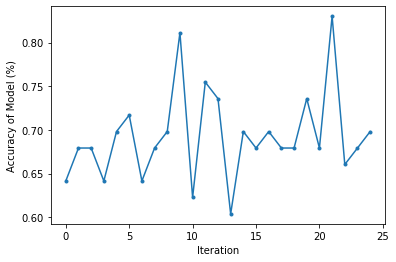

Average Accuracy: 0.6928301886792455


In [221]:
# Graphing the results
plt.plot(iterations,accuracy_scores,'.-')
plt.xlabel("Iteration")
plt.ylabel("Accuracy of Model (%)")
plt.show()
print("Average Accuracy: " + str(sum(accuracy_scores)/25))

<AxesSubplot:>

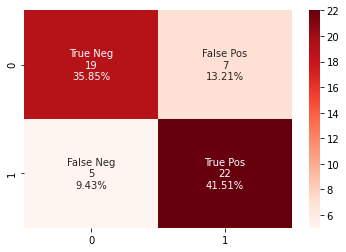

In [223]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.05,random_state=100)
    
model = RandomForestClassifier(n_estimators=1000,max_features="sqrt",min_samples_leaf=1)
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)

results = confusion_matrix(test_Y,pred_Y)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')

In [227]:
models = ["RFC","LR","PCA + LR","KNN","SVC","MLP"]
accuracies = []
train_X,test_X,train_Y,test_Y = train_test_split(mfccs,yy,test_size=0.1,random_state=100)
    # Random Forest
model = RandomForestClassifier(n_estimators=1000)
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))
print(accuracy_score(test_Y,pred_Y))
    #LR
model = LR()
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))
    #PCA + LR
pca_model = PCA(n_components=20)
lr_model = LR()
reduced = pca_model.fit_transform(train_X)
lr_model.fit(reduced,train_Y)
pred_Y = lr_model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))   
    #KNN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))   
    #SVC
model = SVC()
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))  

    #MLPClassifier
model = MLPClassifier()
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
accuracies.append(accuracy_score(test_Y,pred_Y))


print(accuracies,models)

0.7452830188679245


C:\Users\reido\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\reido\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.7452830188679245, 0.5754716981132075, 0.5, 0.6320754716981132, 0.5660377358490566, 0.6698113207547169] ['RFC', 'LR', 'PCA + LR', 'KNN', 'SVC', 'MLP']


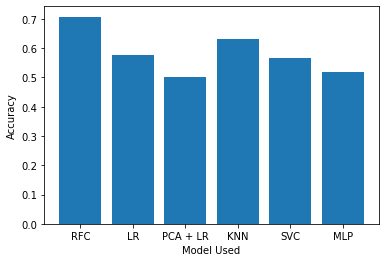

In [225]:
x_pos = [i for i, _ in enumerate(models)]

plt.bar(x_pos,accuracies)
plt.xlabel("Model Used")
plt.ylabel("Accuracy")
plt.xticks(x_pos, models)
plt.show()

In [ ]:
 """   
yy = np.array(labels_binary)
#print(X.shape)
train_X,test_X,train_Y,test_Y = train_test_split(one_big_df,yy,test_size=0.1,random_state=51)
model = RandomForestClassifier()
model.fit(train_X,train_Y)
pred_Y = model.predict(test_X)
print(accuracy_score(test_Y,pred_Y))
#print(pred_Y)
#print(test_Y)

#num_labels = yy.shape[1]
#filter_size = 2
    
model = build_model_graph(len(labels_binary))
model.build((None,20))
print(model.summary())
    
train_X,test_X,train_Y,test_Y = train_test_split(X,yy,test_size=0.2,random_state=42)
num_epochs = 100
num_batch_size = 64
    
model.fit(train_X, train_Y, batch_size=num_batch_size, epochs=num_epochs, validation_data=(test_X, test_Y),
              verbose=1)

#model.fit(train_X,train_Y)
predicted_Y = model.predict(test_X)
#print(accuracy_score(test_Y,predicted_Y))
score = model.evaluate(test_X, test_Y, verbose=0)
print(predicted_Y,test_Y)
print("Testing Accuracy: {0:.2%}".format(score[1]))
print(pred_Y)
print(test_Y)
print(test_X)""""